# Minimal Surfaces
---

In [8]:
import numpy as np
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve

## Laplace operator implementation

In [7]:
def laplace_operator(n, m):
    """
    Create a sparse matrix that represents the Laplace operator on a n x m grid.
    """
    # 1D Laplace operator along x (rows)
    main_diag_x = -4 * np.ones(n)
    off_diag_x = np.ones(n - 1)
    A_x = diags([main_diag_x, off_diag_x, off_diag_x], [0, -1, 1], shape=(n, n))

    # 1D identity matrix along y (columns)
    I_m = eye(m)

    # Combine using Kronecker products to create the 2D Laplace operator
    A = kron(I_m, A_x) + kron(diags([1], [1], shape=(m, m)), eye(n)) + kron(diags([1], [-1], shape=(m, m)), eye(n))

    return A

Testing **laplace_operator** function

In [73]:
n = 3
m = 2
A = laplace_operator(n, m)
if A.shape != (n * m, n * m):
    print("Error: laplace_operator returned a matrix of the wrong shape.")
elif not np.allclose(A.toarray(), np.array([
    [-4, 1, 0, 1, 0, 0],
    [1, -4, 1, 0, 1, 0],
    [0, 1, -4, 0, 0, 1],
    [1, 0, 0, -4, 1, 0],
    [0, 1, 0, 1, -4, 1],
    [0, 0, 1, 0, 1, -4]
])):
    print("Error: laplace_operator returned an incorrect matrix.")
else:
    print("laplace_operator test passed.")

laplace_operator test passed.


## Right hand side vector implementation

In [84]:
def right_hand_side(n, m, intervals, bfuns):
    """
    Create the right hand side of the minimal surface problem.
    
    Parameters:
    ----------
    n : int
        The number of grid points along x.
    m : int
        The number of grid points along y.
    intervals : list of tuples
        The intervals for the boundary functions ((a,b), (c,d)).
    bfuns : list of functions
        The boundary functions (b_xc, b_xd, b_ay, b_by).
    """
    a, b = intervals[0]
    c, d = intervals[1]

    # Create the right hand side
    v = np.zeros(n * m)

    # Fill the boundary values
    v[0:n] = bfuns[0](np.linspace(a, b, n))
    print(v)
    v[(m-1)*n:m*n] = bfuns[1](np.linspace(a, b, n))
    print(v)
    v[0:n*m:n] = bfuns[2](np.linspace(c, d, m))
    print(v)
    v[n-1:n*m:n] = bfuns[3](np.linspace(c, d, m))
    print(v)

    return v

## Minimal surface

In [48]:
def minimal_surface(d, intervals, bfuns):
    """
    Solve the minimal surface problem using the finite element method.
    
    Parameters:
    ----------
    d : float
        The distance between grid points.
    intervals : list of tuples
        The intervals for the boundary functions ((a,b), (c,d)).
    bfuns : list of functions
        The boundary functions (b_xc, b_xd, b_ay, b_by).
    """
    if len(intervals) != 2:
        raise ValueError("The intervals must contain 2 tuples.")
    if len(bfuns) != 4:
        raise ValueError("The boundary functions must contain 4 functions.")
    if not all(len(interval) == 2 for interval in intervals):
        raise ValueError("Each interval must contain 2 values.")
    
    # Number of grid points along x and y
    n = int((intervals[0][1] - intervals[0][0]) / d) + 1
    m = int((intervals[1][1] - intervals[1][0]) / d) + 1
    
    # Create the Laplace operator
    A = laplace_operator(n, m)
    b = right_hand_side(n, m, intervals, bfuns)

    # Solve the linear system
    u = spsolve(A, b)
    u = u.reshape(m, n)

    return u, (n, m)

## Example plot

In [57]:
d = 0.1
intervals = [(0, np.pi), (0, np.pi)]
bfuns = [lambda x: np.sin(x), lambda x: np.sin(x), lambda x: -np.sin(x), lambda x: -np.sin(x)]
u, (n, m) = minimal_surface(d, intervals, bfuns)

In [58]:
n, m

(32, 32)

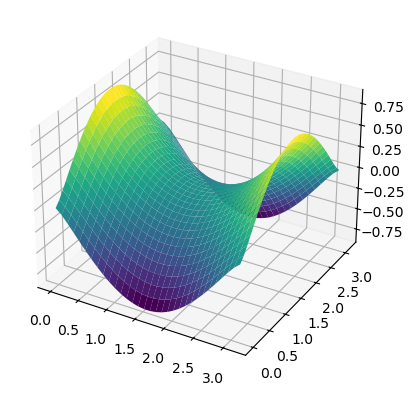

In [59]:
# Plot the solution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(intervals[0][0], intervals[0][1], n)
y = np.linspace(intervals[1][0], intervals[1][1], m)

X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u, cmap='viridis')
plt.show()